## **Model evaluation with Argo floats**

---------------------------------------

**Note**:\
**This script will use data sitting on NCI-Gadi and can be made available upon request.**

---------------------------------------

In this script we will look:
- Defining model domain cross-sections from the EAC SEA-COFS model.
- Collecting Argo floats observations from within a box 0.5deg north and south of the section.
- Plotting a TS-diagram model and obs together to compare variability

Created by Fernando Sobral on 24th Jul 2025

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon
from matplotlib.path import Path

In [2]:
# Reading the model output

# Glob will list all the HIS files and sorted will sort them out ascending.
fls_roms = sorted(glob('/g/data/yj27/cgk561/freerun_1993_2023_CK/output/roms_his*'))

# We will use one file of the model just to use as example.
model = xr.open_dataset(fls_roms[1])

model

<xarray.Dataset> Size: 27GB
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, Nuser: 2,
                    eta_rho: 317, xi_rho: 272, eta_u: 317, xi_u: 271,
                    eta_v: 316, xi_v: 272, eta_psi: 316, xi_psi: 271,
                    ocean_time: 241)
Coordinates:
  * s_rho          (s_rho) float64 240B -0.9715 -0.9156 ... -0.0156 -0.004799
  * s_w            (s_w) float64 248B -1.0 -0.9433 -0.8883 ... -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 690kB ...
    lat_rho        (eta_rho, xi_rho) float64 690kB ...
    lon_u          (eta_u, xi_u) float64 687kB ...
    lat_u          (eta_u, xi_u) float64 687kB ...
    lon_v          (eta_v, xi_v) float64 688kB ...
    lat_v          (eta_v, xi_v) float64 688kB ...
    lon_psi        (eta_psi, xi_psi) float64 685kB ...
    lat_psi        (eta_psi, xi_psi) float64 685kB ...
  * ocean_time     (ocean_time) datetime64[ns] 2kB 1994-01-31T12:00:00 ... 19...
Dimensions without coordinates: tracer, boundary, Nuser, eta_rho, xi_rho,
                                eta_u, xi_u, eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/100)
    ntimes         int32 4B ...
    ndtfast        int32 4B ...
    dt             float64 8B ...
    dtfast         float64 8B ...
    dstart         datetime64[ns] 8B ...
    nHIS           int32 4B ...
    ...             ...
    evaporation    (ocean_time, eta_rho, xi_rho) float32 83MB ...
    rain           (ocean_time, eta_rho, xi_rho) float32 83MB ...
    EminusP        (ocean_time, eta_rho, xi_rho) float32 83MB ...
    swrad          (ocean_time, eta_rho, xi_rho) float32 83MB ...
    sustr          (ocean_time, eta_u, xi_u) float32 83MB ...
    svstr          (ocean_time, eta_v, xi_v) float32 83MB ...
Attributes: (12/34)
    file:              eac_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC
    var_info:          /g/data/fu5/eac/10year_run_insideEnKFreanalysis/freeru...
    ...                ...
    compiler_command:  /apps/openmpi/4.1.4/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 4.2, Monday - March 3, 2025 - 12:45...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sp...
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ANA_SPONGE, ASSUMED_SHAPE...

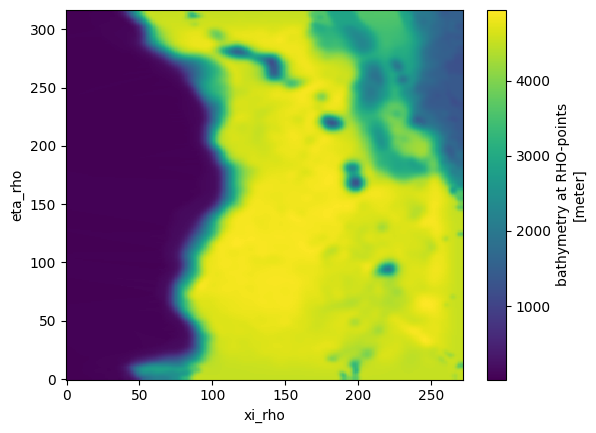

In [3]:
# We also need to read the model's bathymetry

bathy = xr.open_dataset('/g/data/fu5/eac/EACouter_varres_grd_mergedBLbry_uhroms.nc').h

# And lat_rho/lon_rho
lat_rho = xr.open_dataset('/g/data/fu5/eac/EACouter_varres_grd_mergedBLbry_uhroms.nc').lat_rho
lon_rho = xr.open_dataset('/g/data/fu5/eac/EACouter_varres_grd_mergedBLbry_uhroms.nc').lon_rho

# Checking
bathy.plot()

In [4]:
# Reading Argo floats

# Listing and sorting Argo files
files_argo = sorted(glob('/g/data/yj27/data/obs/easycora/PR_PF/*nc'))

print('Checking Argo files: ', files_argo[:5])

# Reading all the files available. Can't use xarray because the dimensions don't match
# Storing in a dictionary, by year.
argo = dict()
for ff in files_argo:
    year = ff.split('/')[-1].split('_')[2]
    argo[year] = xr.open_dataset(ff) 


argo.keys()

Checking Argo files:  ['/g/data/yj27/data/obs/easycora/PR_PF/ECO_DMQCGL01_2001_PR_PF.nc', '/g/data/yj27/data/obs/easycora/PR_PF/ECO_DMQCGL01_2002_PR_PF.nc', '/g/data/yj27/data/obs/easycora/PR_PF/ECO_DMQCGL01_2003_PR_PF.nc', '/g/data/yj27/data/obs/easycora/PR_PF/ECO_DMQCGL01_2004_PR_PF.nc', '/g/data/yj27/data/obs/easycora/PR_PF/ECO_DMQCGL01_2005_PR_PF.nc']


dict_keys(['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])

84 is the first non nan xi_value
99 is the first non nan xi_value
111 is the first non nan xi_value
90 is the first non nan xi_value
76 is the first non nan xi_value
Plotting the year of 2001 for Argo
Plotting the year of 2002 for Argo
Plotting the year of 2003 for Argo
Plotting the year of 2004 for Argo
Plotting the year of 2005 for Argo
Plotting the year of 2006 for Argo
Plotting the year of 2007 for Argo
Plotting the year of 2008 for Argo
Plotting the year of 2009 for Argo
Plotting the year of 2010 for Argo
Plotting the year of 2011 for Argo
Plotting the year of 2012 for Argo
Plotting the year of 2013 for Argo
Plotting the year of 2014 for Argo
Plotting the year of 2015 for Argo
Plotting the year of 2016 for Argo
Plotting the year of 2017 for Argo
Plotting the year of 2018 for Argo
Plotting the year of 2019 for Argo
Plotting the year of 2020 for Argo
Plotting the year of 2021 for Argo
Plotting the year of 2022 for Argo
Plotting the year of 2023 for Argo


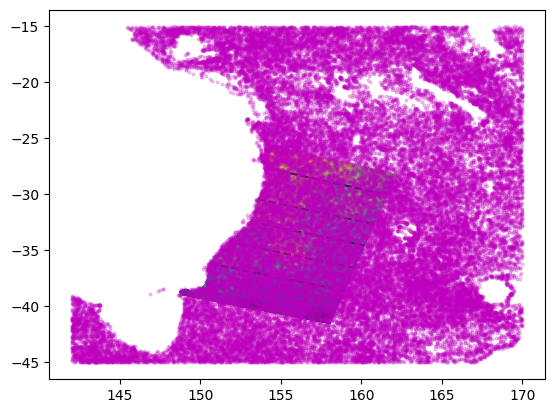

In [5]:
# Visualizing model domain and plotting the sections on the SST that will be used.

# Defining sections in the model to be used in the validation
# Since Argo floats are not expected to colect information on the shelf and slope, we'll mask depths shallower than 2000 m.

# This condition will only mask the depth shallower than 2000 m on the west side of the domain.

condition = (
            (lon_rho < 154.3) & (bathy >= 2000)
            ) | (
            (lon_rho >= 154.3)
            )
SST = model.temp.isel(ocean_time=0, s_rho=-1).where(condition)

# Defining indexes for the model coodinates to collect the latitude and longitude
slice_idx = [272, 210, 165, 118, 70]

# Getting the xi_rho index where we want to start the sections.
# We will use SST, and collect the first non NAN value, after using the filtering conditons above.
lon_st_section = list()
for II in slice_idx:
    for enu, vv in enumerate(SST.isel(eta_rho=II).values):
        if ~np.isnan(vv):
            print(f'{enu} is the first non nan xi_value')
            lon_st_section.append(enu)
            break


lat_brisbane = lat_rho.isel(eta_rho=slice_idx[0], xi_rho=slice(lon_st_section[0], None))
lat_coffsH   = lat_rho.isel(eta_rho=slice_idx[1], xi_rho=slice(lon_st_section[1], None))
lat_forster  = lat_rho.isel(eta_rho=slice_idx[2], xi_rho=slice(lon_st_section[2], None))
lat_sydney   = lat_rho.isel(eta_rho=slice_idx[3], xi_rho=slice(lon_st_section[3], None))
lat_narooma  = lat_rho.isel(eta_rho=slice_idx[4], xi_rho=slice(lon_st_section[4], None))

lon_brisbane = lon_rho.isel(eta_rho=slice_idx[0], xi_rho=slice(lon_st_section[0], None))
lon_coffsH   = lon_rho.isel(eta_rho=slice_idx[1], xi_rho=slice(lon_st_section[1], None))
lon_forster  = lon_rho.isel(eta_rho=slice_idx[2], xi_rho=slice(lon_st_section[2], None))
lon_sydney   = lon_rho.isel(eta_rho=slice_idx[3], xi_rho=slice(lon_st_section[3], None))
lon_narooma  = lon_rho.isel(eta_rho=slice_idx[4], xi_rho=slice(lon_st_section[4], None))


# Plotting to see if we have the right information
plt.pcolormesh(lon_rho, lat_rho, SST)
plt.plot(lon_brisbane, lat_brisbane, '--k')
plt.plot(lon_coffsH, lat_coffsH, '--k')
plt.plot(lon_forster, lat_forster, '--k')
plt.plot(lon_sydney, lat_sydney, '--k')
plt.plot(lon_narooma, lat_narooma, '--k');


# Plotting all Argo profile locations filtering for the model's domain
for YY, DA in argo.items():
    print(f'Plotting the year of {YY} for Argo')
    plt.plot(DA.LONGITUDE, DA.LATITUDE, 'om', markersize=2, alpha=0.2)


In [6]:
# This function creates a polygon 0.5deg above and below the section coordinates 
# It will be used to detect if an Argo profile falls within that box.

def create_polygon(lon , lat):
    
    # Combine lon and lat into a list of (x, y) tuples for Shapely
    points_for_line = list(zip(lon, lat))

    # Create a LineString object from your section points
    line = LineString(points_for_line)
    buffer_distance = 0.5
    buffered_polygon_shapely = line.buffer(buffer_distance, cap_style=2, join_style=2)

    polygon_lon, polygon_lat = buffered_polygon_shapely.exterior.xy
    poly_lon = np.array(polygon_lon)
    poly_lat = np.array(polygon_lat)
    path_vertices = np.vstack((poly_lon, poly_lat)).T
    poly_path = Path(path_vertices)
    
    return poly_path, poly_lon, poly_lat

In [7]:
# Now, we will select only the profiles falling within a box of 0.5deg from the cross-section up north and south.

poly_path_bris, poly_lon_bris, poly_lat_bris = create_polygon(lon_brisbane, lat_brisbane)
poly_path_coff, poly_lon_coff, poly_lat_coff = create_polygon(lon_coffsH, lat_coffsH)
poly_path_fors, poly_lon_fors, poly_lat_fors = create_polygon(lon_forster, lat_forster)
poly_path_sydn, poly_lon_sydn, poly_lat_sydn = create_polygon(lon_sydney, lat_sydney)
poly_path_naro, poly_lon_naro, poly_lat_naro = create_polygon(lon_narooma, lat_narooma)

# These dictionaries will store crucial information such as:
# LON, LAT, TEMP, PSAL, TIME
coord_temp_salt_time_bris = dict()
coord_temp_salt_time_coff = dict()
coord_temp_salt_time_fors = dict()
coord_temp_salt_time_sydn = dict()
coord_temp_salt_time_naro = dict()

# This coord will be use to make the plot
is_inside_bris = list()
is_inside_coff = list()
is_inside_fors = list()
is_inside_sydn = list()
is_inside_naro = list()

for YY, DA in argo.items():
    # Temporary storage inside an year
    tmp_bris = list()
    tmp_coff = list()
    tmp_fors = list()
    tmp_sydn = list()
    tmp_naro = list()
    for LON, LAT, TEMP, PSAL, TIME in zip(DA.LONGITUDE.values, DA.LATITUDE.values, DA.TEMP.values, DA.PSAL.values, DA.TIME.values):
        coord = np.array([[LON, LAT]])
        if poly_path_bris.contains_points(coord):
            is_inside_bris.append([coord[0][0], coord[0][1]])
            tmp_bris.append([LON,LAT, TEMP, PSAL, TIME])

        elif poly_path_coff.contains_points(coord):
            is_inside_coff.append([coord[0][0], coord[0][1]])
            tmp_coff.append([LON,LAT, TEMP, PSAL, TIME])

        elif poly_path_fors.contains_points(coord):
            is_inside_fors.append([coord[0][0], coord[0][1]])
            tmp_fors.append([LON,LAT, TEMP, PSAL, TIME])

        elif poly_path_sydn.contains_points(coord):
            is_inside_sydn.append([coord[0][0], coord[0][1]])
            tmp_sydn.append([LON,LAT, TEMP, PSAL, TIME])

        elif poly_path_naro.contains_points(coord):
            is_inside_naro.append([coord[0][0], coord[0][1]])
            tmp_naro.append([LON,LAT, TEMP, PSAL, TIME])
    
    # Storing all the information for that year.
    coord_temp_salt_time_bris[YY] = tmp_bris
    coord_temp_salt_time_coff[YY] = tmp_coff
    coord_temp_salt_time_fors[YY] = tmp_fors
    coord_temp_salt_time_sydn[YY] = tmp_sydn
    coord_temp_salt_time_naro[YY] = tmp_naro
        

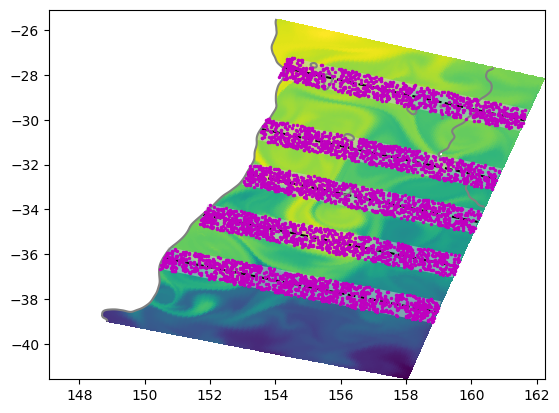

In [8]:
condition = (
            (lon_rho < 154.3) & (bathy >= 2000)
            ) | (
            (lon_rho >= 154.3)
            )
SST = model.temp.isel(ocean_time=0, s_rho=-1).where(condition)
plt.pcolormesh(lon_rho, lat_rho, SST)
plt.plot(lon_brisbane, lat_brisbane, '--k')
plt.plot(lon_coffsH, lat_coffsH, '--k')
plt.plot(lon_forster, lat_forster, '--k')
plt.plot(lon_sydney, lat_sydney, '--k')
plt.plot(lon_narooma, lat_narooma, '--k');

plt.contour(bathy.lon_rho, bathy.lat_rho, bathy, levels=[2000], colors='gray')

plt.fill(poly_lon_bris, poly_lat_bris, 'lightgray', alpha=0.5, label='Polygon Area')
plt.plot(np.array(is_inside_bris)[:, 0], np.array(is_inside_bris)[:, 1], '.m', markersize=3)

plt.fill(poly_lon_coff, poly_lat_coff, 'lightgray', alpha=0.5, label='Polygon Area')
plt.plot(np.array(is_inside_coff)[:, 0], np.array(is_inside_coff)[:, 1], '.m', markersize=3)

plt.fill(poly_lon_fors, poly_lat_fors, 'lightgray', alpha=0.5, label='Polygon Area')
plt.plot(np.array(is_inside_fors)[:, 0], np.array(is_inside_fors)[:, 1], '.m', markersize=3)

plt.fill(poly_lon_sydn, poly_lat_sydn, 'lightgray', alpha=0.5, label='Polygon Area')
plt.plot(np.array(is_inside_sydn)[:, 0], np.array(is_inside_sydn)[:, 1], '.m', markersize=3)

plt.fill(poly_lon_naro, poly_lat_naro, 'lightgray', alpha=0.5, label='Polygon Area')
plt.plot(np.array(is_inside_naro)[:, 0], np.array(is_inside_naro)[:, 1], '.m', markersize=3)

In [9]:
# And finally, extracting ROMS temperature and salinity from the sections

temp_brisbane = model.temp.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[0], xi_rho=slice(lon_st_section[0], None))
temp_coffsH   = model.temp.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[1], xi_rho=slice(lon_st_section[1], None))
temp_forster  = model.temp.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[2], xi_rho=slice(lon_st_section[2], None))
temp_sydney   = model.temp.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[3], xi_rho=slice(lon_st_section[3], None))
temp_narooma  = model.temp.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[4], xi_rho=slice(lon_st_section[4], None))

salt_brisbane = model.salt.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[0], xi_rho=slice(lon_st_section[0], None))
salt_coffsH   = model.salt.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[1], xi_rho=slice(lon_st_section[1], None))
salt_forster  = model.salt.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[2], xi_rho=slice(lon_st_section[2], None))
salt_sydney   = model.salt.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[3], xi_rho=slice(lon_st_section[3], None))
salt_narooma  = model.salt.isel(ocean_time=slice(0, 50), eta_rho=slice_idx[4], xi_rho=slice(lon_st_section[4], None))

#### **Peparing for the comparison plot**

In [10]:
import gsw, stats


In [11]:

def water_density():
    tempL = np.linspace(0, 30, 156)
    saltL = np.linspace(33.5, 37, 156)
    Tg, Sg = np.meshgrid(tempL,saltL)
    sigma_theta = gsw.sigma0(Sg, Tg)
    return Tg, Sg, sigma_theta

In [18]:
Tg, Sg, sigma_theta = water_density()

##### **For Brisbane**

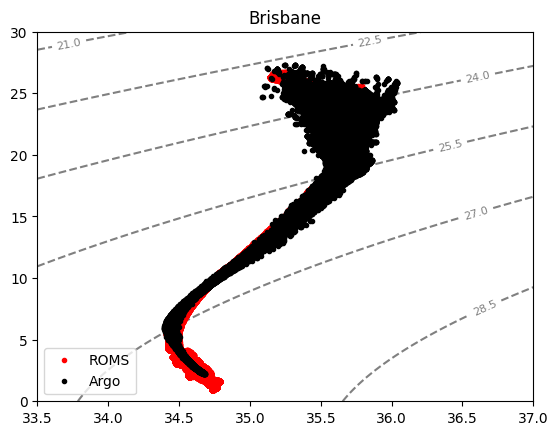

In [50]:
plt.plot(salt_brisbane.values.ravel(), temp_brisbane.values.ravel(), '.', color='r')
for YY, DA in coord_temp_salt_time_bris.items():
    for _, _, TEMP, PSAL, _ in DA:
        plt.plot(PSAL, TEMP, '.', color='k')
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1, linestyles='dashed')
cl = plt.clabel(cs, fontsize=8, inline=True, fmt='%.1f')        
plt.title('Brisbane')
plt.legend(['ROMS', 'Argo']);

##### **For Coffs Harbour**

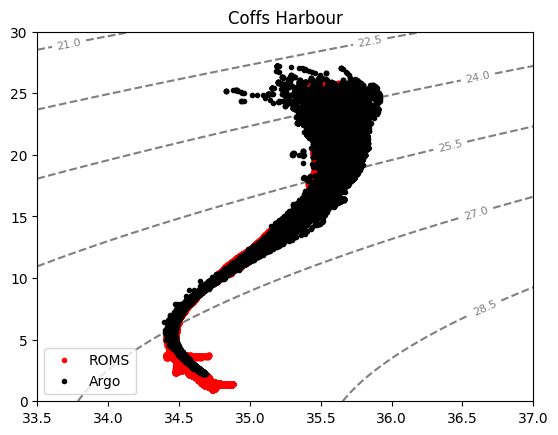

In [49]:
plt.plot(salt_coffsH.values.ravel(), temp_coffsH.values.ravel(), '.', color='r')
for YY, DA in coord_temp_salt_time_coff.items():
    for _, _, TEMP, PSAL, _ in DA:
        plt.plot(PSAL, TEMP, '.', color='k')
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1, linestyles='dashed')
cl = plt.clabel(cs, fontsize=8, inline=True, fmt='%.1f')        
plt.title('Coffs Harbour')
plt.legend(['ROMS', 'Argo']);

##### **For Forster**

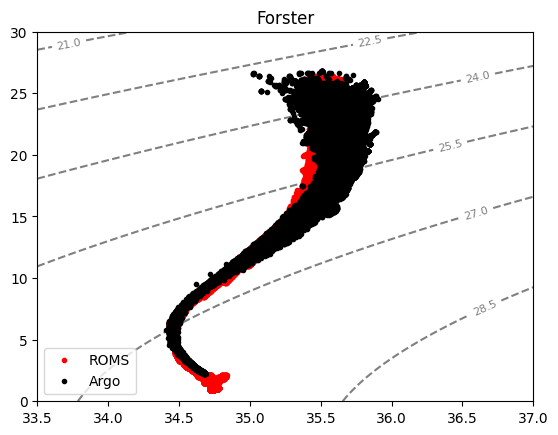

In [48]:
plt.plot(salt_forster.values.ravel(), temp_forster.values.ravel(), '.', color='r')
for YY, DA in coord_temp_salt_time_fors.items():
    for _, _, TEMP, PSAL, _ in DA:
        plt.plot(PSAL, TEMP, '.', color='k')
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1, linestyles='dashed')
cl = plt.clabel(cs, fontsize=8, inline=True, fmt='%.1f')
plt.title('Forster')
plt.legend(['ROMS', 'Argo']);

##### **For Sydney**

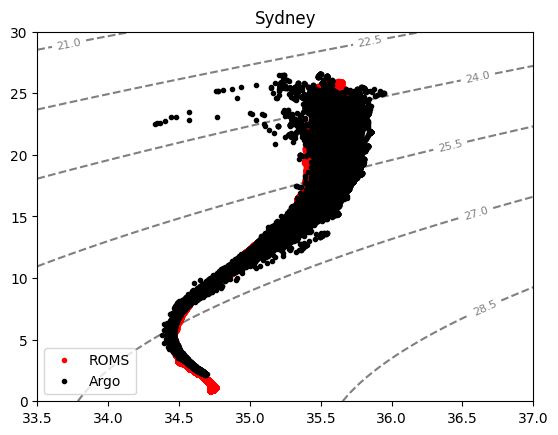

In [47]:
plt.plot(salt_sydney.values.ravel(), temp_sydney.values.ravel(), '.', color='r')
for YY, DA in coord_temp_salt_time_sydn.items():
    for _, _, TEMP, PSAL, _ in DA:
        plt.plot(PSAL, TEMP, '.', color='k')
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1, linestyles='dashed')
cl = plt.clabel(cs, fontsize=8, inline=True, fmt='%.1f')        
plt.title('Sydney')
plt.legend(['ROMS', 'Argo']);

##### **For Narooma**

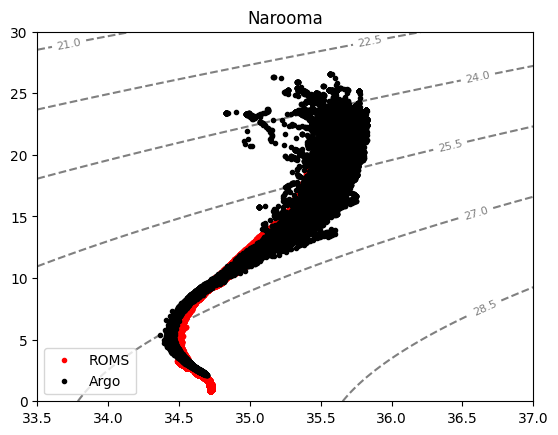

In [51]:
plt.plot(salt_narooma.values.ravel(), temp_narooma.values.ravel(), '.', color='r')
for YY, DA in coord_temp_salt_time_naro.items():
    for _, _, TEMP, PSAL, _ in DA:
        plt.plot(PSAL, TEMP, '.', color='k')
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1, linestyles='dashed')
cl = plt.clabel(cs, fontsize=8, inline=True, fmt='%.1f')        
plt.title('Narooma')
plt.legend(['ROMS', 'Argo']);